### Овечкина Лидия

Дано 6 датасетов, в которых лежат данные по 6 районам, все значения взаимосвязаны.  
Необходимо востановить зависимость для последнего района.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
import scipy.stats as stats
import pymc as pm
import arviz as az

In [3]:
data1 = pd.read_csv('data_01.csv')
data2 = pd.read_csv('data_02.csv')
data3 = pd.read_csv('data_03.csv')
data4 = pd.read_csv('data_04.csv')
data5 = pd.read_csv('data_05.csv')
data6 = pd.read_csv('data_06.csv')

In [4]:
# all_data = [data1, data2, data3, data4, data5, data6]
# N_values = [len(d) for d in all_data]
# M = len(all_data)

# np.random.seed(42)

# alpha_real = np.random.normal(2.5, 0.5, size=M)
# beta_real = np.random.beta(6, 1, size=M)
# eps_real = np.concatenate([np.random.normal(0, 0.5, size=n) for n in N_values])

# y_m = np.zeros(sum(N_values))
# x_m = np.concatenate([np.random.normal(10, 1, size=n) for n in N_values])
# idx = np.concatenate([np.repeat(i, n) for i, n in enumerate(N_values)])
# y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

# _, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, constrained_layout=True)
# ax = np.ravel(ax)
# j, k = 0, 0
# for i, d in enumerate(all_data):
#     k += len(d)
#     ax[i].scatter(x_m[j:k], y_m[j:k])
#     ax[i].set_xlabel(f'x_{i}')
#     ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
#     ax[i].set_xlim(6, 15)
#     ax[i].set_ylim(7, 17)
#     j = k
# plt.tight_layout()

In [5]:
# all_data = [data1, data2, data3, data4, data5, data6]

# with pm.Model() as hierarchical_model:

#     mu_a = pm.Normal('mu_a', mu=0, sigma=10)
#     sigma_a = pm.HalfNormal('sigma_a', sigma=10)
#     mu_b = pm.Normal('mu_b', mu=0, sigma=10)
#     sigma_b = pm.HalfNormal('sigma_b', sigma=10)

#     a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=len(all_data))
#     b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=len(all_data))


#     y_est = a[5] + b[5] * data6['x']
#     y_like = pm.Normal('y_like', mu=y_est, sigma=1, observed=data6['y'])
#     trace = pm.sample(1000, tune=1000, cores=4)
    
# print(pm.summary(trace))

In [6]:
N_list = [len(data1), len(data2), len(data3), len(data4), len(data5), len(data6)]
N_sum = sum(N_list)
print(N_sum)

262


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 3_000 tune and 5_000 draw iterations (9_000 + 15_000 draws total) took 198 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


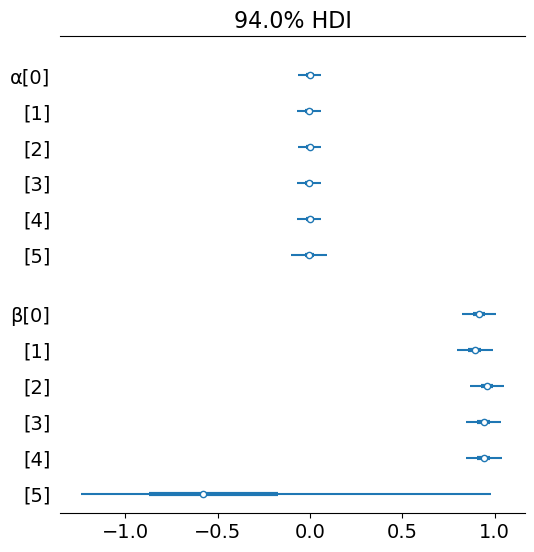

In [7]:
all_data = [data1, data2, data3, data4, data5, data6]

idd = []
for i, d in enumerate(all_data):
    all_data[i]['x'] = (d['x'] - d['x'].mean()) / d['x'].std()
    all_data[i]['y'] = (d['y'] - d['y'].mean()) / d['y'].std()
    idd.extend([i] * len(d))

x_m = np.concatenate([d['x'] for d in all_data])
y_m = np.concatenate([d['y'] for d in all_data])
M = len(all_data)

with pm.Model() as hierarchical_model:

    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=1)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=2)
    β_μ = pm.Normal('β_μ', mu=0, sigma=0.5)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 2)
    ν = pm.Exponential('ν', 1/20)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idd] + β[idd] * x_m,
    sigma=ε, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(5000, tune=3000, target_accept=0.95)

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

In [8]:
summary = az.summary(trace_hm)
print(summary)

            mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α_μ_tmp   -0.003   0.032  -0.065    0.051      0.001    0.001    3320.0   
β_μ        0.545   0.310  -0.031    1.026      0.008    0.006    1449.0   
α_tmp[0]  -0.001   0.033  -0.063    0.058      0.000    0.000    5122.0   
α_tmp[1]  -0.005   0.034  -0.071    0.058      0.000    0.000    5864.0   
α_tmp[2]  -0.002   0.032  -0.063    0.058      0.000    0.000    4872.0   
α_tmp[3]  -0.004   0.033  -0.069    0.057      0.000    0.000    5368.0   
α_tmp[4]  -0.002   0.034  -0.069    0.059      0.000    0.000    6512.0   
α_tmp[5]  -0.003   0.054  -0.104    0.093      0.001    0.001    4308.0   
β[0]       0.914   0.049   0.824    1.009      0.000    0.000   12979.0   
β[1]       0.893   0.052   0.795    0.990      0.001    0.000    8958.0   
β[2]       0.958   0.048   0.868    1.050      0.000    0.000    9722.0   
β[3]       0.940   0.050   0.844    1.033      0.000    0.000   12569.0   
β[4]       0.941   0.051 

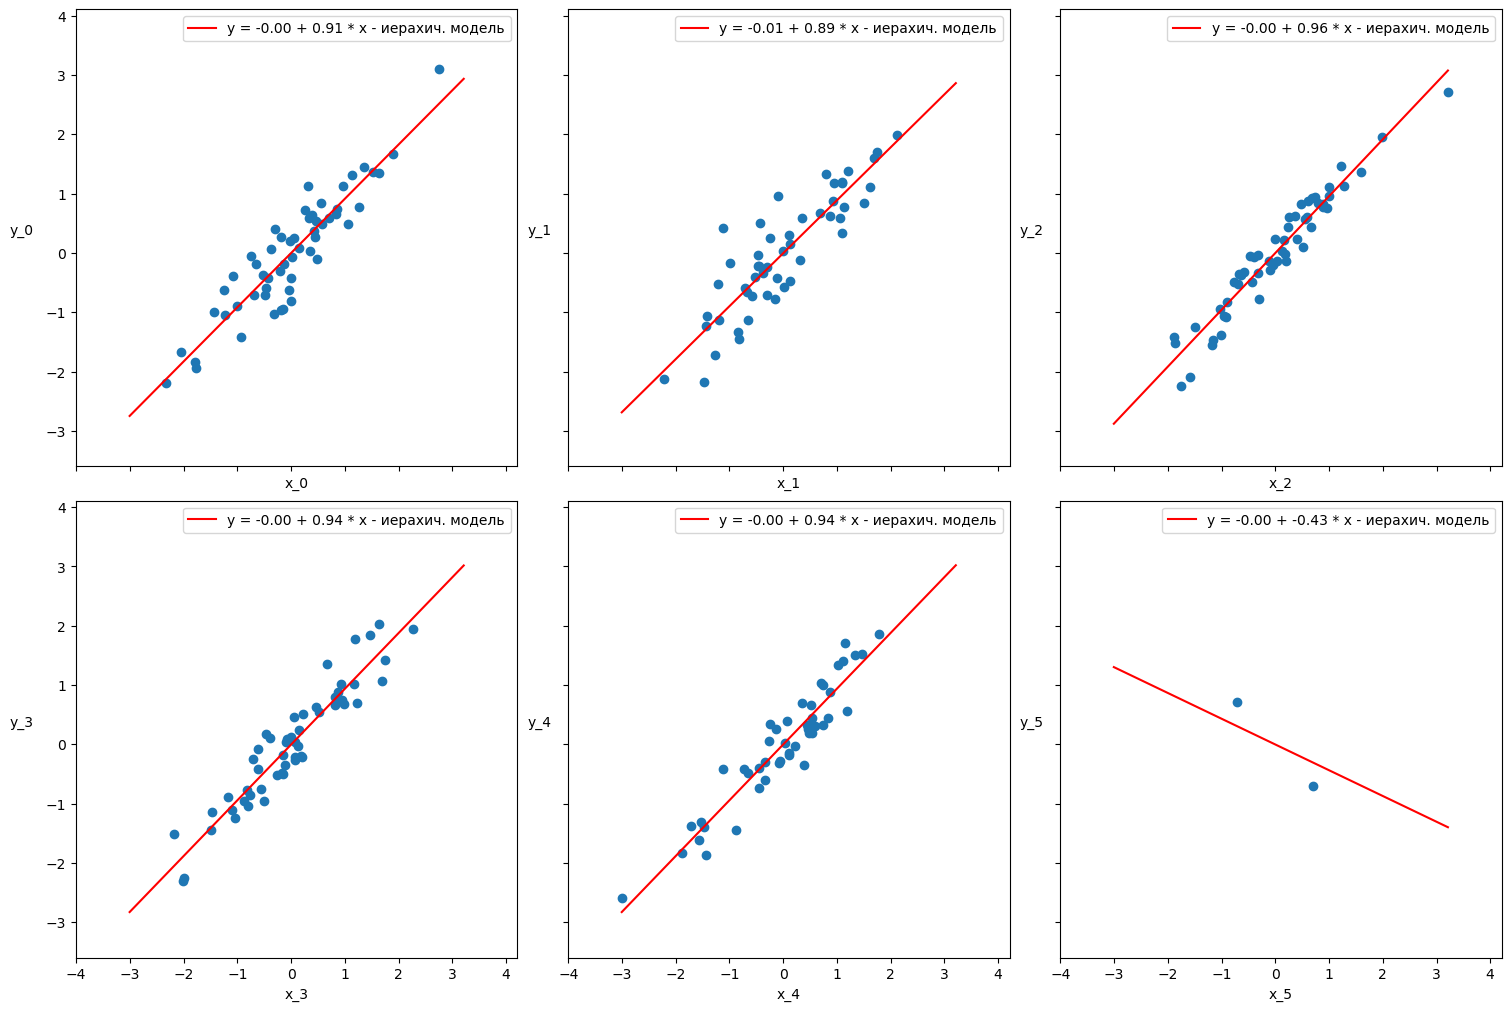

In [9]:
N_values = [len(d) for d in all_data]

_, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})

ax = np.ravel(ax)
j, k = 0, 0
x_range = np.linspace(x_m.min(), x_m.max(), 10)

for i in range(M):
    j = k
    k += N_values[i]
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x'+' - иерахич. модель')

    ax[i].legend()
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)